<img src="img/affiche_formation_5.png" alt="Affiche Centrale IA Formation 5 Interprétabilité des modèles de Machine Learning Amine Zaamoun" width="600" height="300"/>

# Interprétabilité des modèles de Machine Learning
*N.B : Les explications ont été tirées de cet article : https://christophm.github.io/interpretable-ml-book/shapley.html et de ce lien github : https://github.com/slundberg/shap.*

L'interprétabilité des modèles de Machine Learning est un sujet majeur en Data Science. En effet, beaucoup de modèles complexes tels que la star des compétitions Kaggle **XGBoost** ou encore les **Random Forests** performent en général beaucoup mieux que certains modèles plus simples à comprendre et expliquer tels que la **Régression Logistique** ou l'**Arbre de Décision**. \
Cette notion est encore plus importante lorsque nous sommes confrontés à des contraintes légales d'explicativité aux clients, comme par exemple au sein de Crédit Agricole Consumer Finance, entreprise dans laquelle je fais mon alternance en tant que Data Scientist. \
La question qu'on doit se poser alors est : "Doit-on développer un modèle simple à expliquer, quitte à perdre en performance ou plutôt se focaliser sur les performances prédictives de notre modèle mais perdre notre capacité à l'expliquer simplement et clairement ?"

Grâce à des librairies telles que **shap** en Python, il n'est plus nécessaire de faire cet arbitrage, la performance ET l'explicativité sont désormais possible :

SHAP (SHapley Additive exPlanations) est une approche de la théorie des jeux pour expliquer la sortie de n'importe quel modèle de Machine Learning. Une prédiction peut être expliquée en supposant que chaque valeur de caractéristique de l'instance est un "joueur" dans un jeu où la prédiction est le gain.

<img src="img/image_schema_shap_github.svg" alt="Schéma interprétabilité SHAP sur GitHub" width="600" height="300"/>

*BP : Pression artérielle* \
*BMI : Indice de masse corporelle*

Dans cet exemple tiré du git de la librairie **shap** en Python, nous avons développé un modèle complexe considéré comme "black box" afin de prédire si une personne a une maladie cardiovasculaire ou non. Le but de cette librairie est de pouvoir comprendre ce qui se cache derrière les prédictions de cette black box afin de pouvoir plus facilement expliquer ses résultats aux parties prenantes d'un projet de Data Science. \
Cet individu a ainsi, sur la seule base de ces 4 caractéristiques qui contribuent chacun positivement ou négativement à la prédiction, une probabilité de 0.4 d'être atteint de maladie cardiovasculaire comme on veut le voir dans l'**output** du modèle.

In [1]:
# Import de l'environnement classique en Data Science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import de la fonction permettant de séparer notre jeu de données en jeux d'entraînement et de test
from sklearn.model_selection import train_test_split

# Import de la fonction permettant d'implémenter un modèle xgboost
import xgboost as xgb

# Import de fonctions permettant d'afficher une courbe roc et de calculer le score 'area under the curve'
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Import de la fonction permettant d'afficher plusieurs métriques de performance liées à un modèle de classification
from sklearn.metrics import classification_report

# Import du package permettant de mieux interpréter les résultats prédictifs de notre modèle de Machine Learning
import shap
shap.initjs()

# Commande permettant d'afficher des graphiques directement dans ce notebook
%matplotlib inline

In [2]:
# Import du fichier 'titanic' (présent dans la librairie seaborn) dans un DataFrame nommé df
df = sns.load_dataset('titanic')

# Affichage des 10 premières lignes de df
df.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


Le [jeu de données](https://www.kaggle.com/c/titanic/data) que nous venons d'importer représente les individus d'un des drames les plus connus au monde : le naufrage du titanic. L'idée principal est de pouvoir prédire si un individu, en fonction de ses caractéristiques, va survivre ou non.

Les caractéristiques des individus et leurs types sont les suivants :

Attribute 1: (qualitative)\
**pclass** / **class** (*Classe de ticket*)
- 1st : Classe sociale élevée
- 2nd : Classe sociale moyenne
- 3rd : Classe sociale basse

Attribute 2: (qualitative)\
**sex** (*Genre*)
- male : sexe masculin
- female : sexe féminin

Attribute 3: (numerical)\
**age** in years (*Âge en années*)

Attribute 4: (qualitative)\
**sibsp** (*Nombre de frères et soeurs / conjoints à bord du Titanic*)

Attribute 5: (qualitative)\
**parch** (*Nombre de parents / enfants à bord du Titanic*)

Attribute 6: (numerical)\
**fare** in dollars (*Prix du ticket*)
    
Attribute 7: (qualitative)\
**embarked** / **embark_town** (*Port d'embarcation*)
- C : Cherbourg
- Q : Queenstown
- S : Southampton

Attibute 8: (qualitative)\
**who** (*Type de l'individu*)
- man : homme
- woman : femme
- child : enfant

Attribute 9: (boolean)\
**adult_male** (*1 si l'individu est un homme adulte*)

Attribute 10: (qualitative)\
**Deck** (*Numéro du pont dans le bateau*)

Attribute 11: (qualitative)\
**alive** (*1 si l'individu est encore en vie à l'heure où le jeu de données a été publié en ligne*)

Attribute 12: (qualitative)\
**alone** (*1 si l'individu a prix un séjour seul au bord du Titanic*)

La variable cible `survived` (Première colonne) contient 2 modalités: 1 pour "L'individu a survécu" et 0 pour le cas contraire.

In [3]:
# Affichage de quelques informations sur df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB


In [4]:
# Comptage du nombre de doublons
df.duplicated().sum()

107

In [5]:
df = df.drop_duplicates(keep = 'last')

In [6]:
# Affichage des nouvelles dimensions de notre jeu de données
df.shape

(784, 15)

In [7]:
# Suppression des colonnes 'embarked', 'class', 'adult_male' et 'alive'
df = df.drop(['embarked', 'class', 'adult_male', 'alive'], axis = 1)

In [8]:
# Transformation des variables catégorielles de notre jeu de données en indicatrices
df = df.join(pd.get_dummies(df['pclass'], prefix = 'pclass_'))
df = df.join(pd.get_dummies(df['sex'], prefix = 'sex_'))
df = df.join(pd.get_dummies(df['sibsp'], prefix = 'sibsp_'))
df = df.join(pd.get_dummies(df['parch'], prefix = 'parch_'))
df = df.join(pd.get_dummies(df['who'], prefix = 'who_'))
df = df.join(pd.get_dummies(df['deck'], prefix = 'deck_'))
df = df.join(pd.get_dummies(df['embark_town'], prefix = 'embark_town_'))
df = df.join(pd.get_dummies(df['alone'], prefix = 'alone_'))

df = df.drop(['pclass', 'sex', 'sibsp', 'parch', 'who', 'deck', 'embark_town', 'alone'], axis = 1)

In [9]:
df.head(10)

,survived,age,fare,pclass__1,pclass__2,pclass__3,sex__female,sex__male,sibsp__0,sibsp__1,...,deck__C,deck__D,deck__E,deck__F,deck__G,embark_town__Cherbourg,embark_town__Queenstown,embark_town__Southampton,alone__False,alone__True
0,0,22.0,7.2500,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,1,1,0
1,1,38.0,71.2833,1,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,1,0
2,1,26.0,7.9250,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,0,1
3,1,35.0,53.1000,1,0,0,1,0,0,1,...,1,0,0,0,0,0,0,1,1,0
5,0,NaN,8.4583,0,0,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1
6,0,54.0,51.8625,1,0,0,0,1,1,0,...,0,0,1,0,0,0,0,1,0,1
7,0,2.0,21.0750,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
8,1,27.0,11.1333,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,1,1,0
9,1,14.0,30.0708,0,1,0,1,0,0,1,...,0,0,0,0,0,1,0,0,1,0
10,1,4.0,16.7000,0,0,1,1,0,0,1,...,0,0,0,0,1,0,0,1,1,0


In [10]:
# Stockage de la variable cible 'survived' dans un vecteur 'target'
target = df['survived']

# Stockage des variables explicatives dans un DataFrame nommé 'explanatory_vars'
explanatory_vars = df.drop(['survived'], axis = 1)

# Séparation en un jeu d'apprentissage contenant 80% des données et un jeu de test avec les données restantes
X_train, X_test, y_train, y_test = train_test_split(explanatory_vars, target, test_size = 0.2, random_state = 42)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


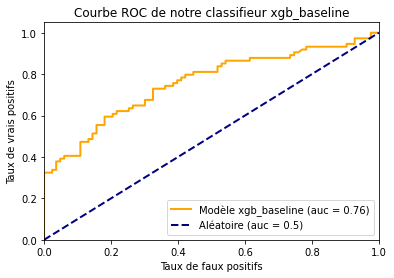

In [11]:
# Instanciation d'un classifieur xgboost nommé "xgb_baseline" à l'aide de la classe XGBClassifier
xgb_baseline = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'aucpr', learning_rate = 0.1, n_estimators = 500,
                                 max_depth = 10, scale_pos_weight = round(y_train.value_counts()[0] / y_train.value_counts()[1], 2),
                                 seed = 42)

# Entraînement de notre modèle xgb_baseline
xgb_baseline.fit(X_train, y_train)

# stockage des probabilités pour les individus de X_test d'appartenir à la classe 0 ou la classe 1 dans proba_xgb_baseline
proba_xgb_baseline = xgb_baseline.predict_proba(X_test)

# Application de la fonction roc_curve() à y_test et la deuxième colonne de proba_xgb_baseline,
# en précisant que le label positif dans notre cas est 1
fpr_xgb, tpr_xgb, seuils_xgb = roc_curve(y_test, proba_xgb_baseline[:, 1], pos_label = 1)

# Calcul dans roc_auc de l'AUC correspondant aux valeurs de fpr et tpr
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.plot(fpr_xgb, tpr_xgb, color = 'orange', lw = 2, label = 'Modèle xgb_baseline (auc = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--', label = 'Aléatoire (auc = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC de notre classifieur xgb_baseline')
plt.legend(loc = "lower right")
plt.show()

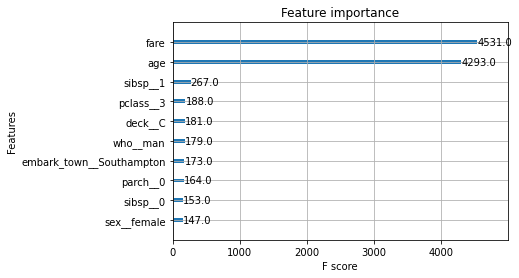

In [12]:
xgb.plot_importance(xgb_baseline, max_num_features = 10);

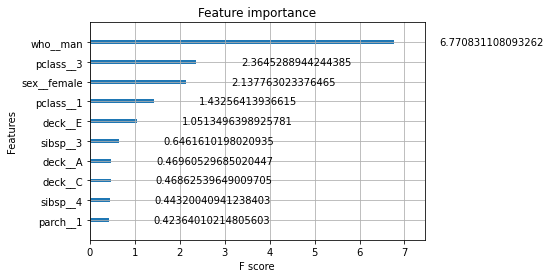

In [13]:
xgb.plot_importance(xgb_baseline, importance_type = 'gain', max_num_features = 10);

## Zoom sur les SHAP values

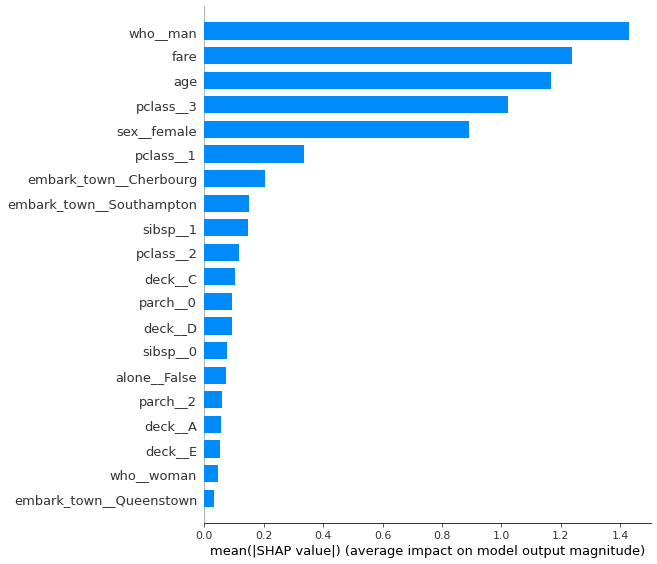

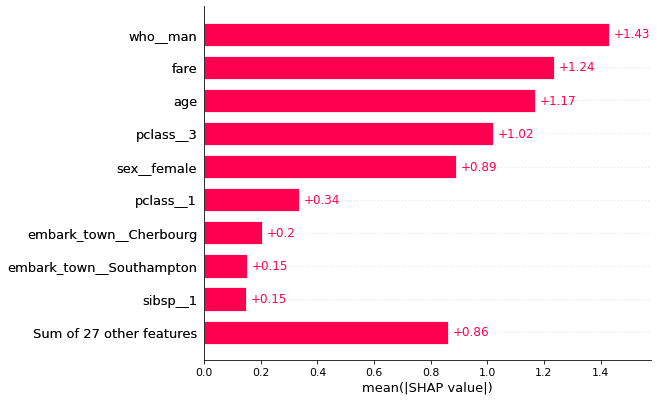

In [29]:
explainer = shap.Explainer(xgb_baseline)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type = "bar")
shap.plots.bar(shap_values)

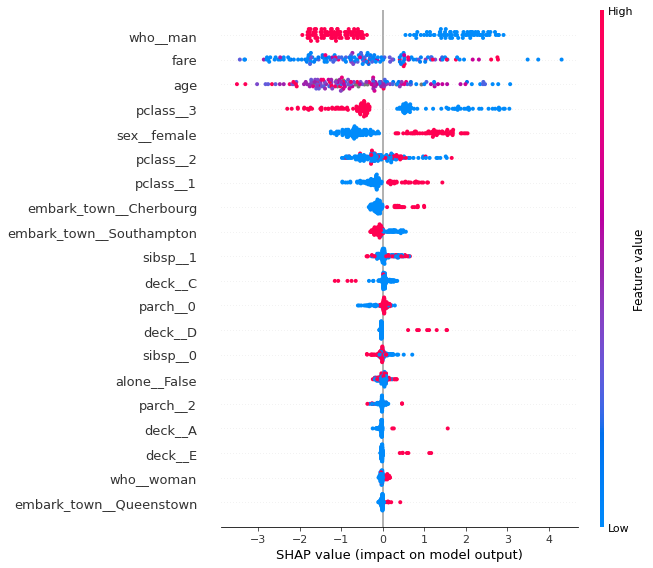

In [31]:
shap.summary_plot(shap_values, X_test)

In [16]:
pd.crosstab(df['survived'], df['who__man'])

who__man,0,1
survived,,
0,95,366
1,238,85


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


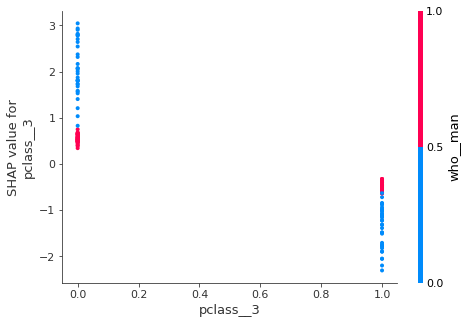

In [17]:
shap.dependence_plot('pclass__3', shap_values, X_test, interaction_index = 'who__man')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


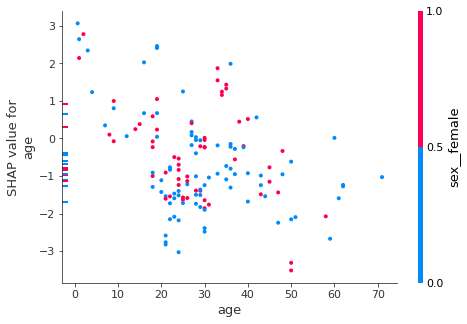

In [18]:
shap.dependence_plot('age', shap_values, X_test, interaction_index = 'sex__female')

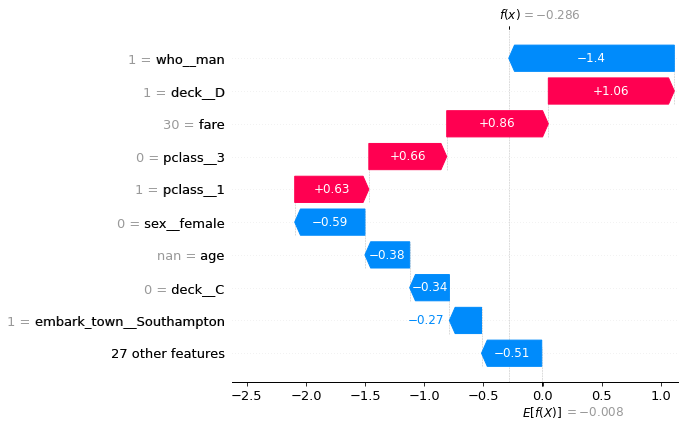

In [22]:
shap.plots.waterfall(shap_values[3])

In [26]:
shap.plots.force(shap_values[3, :], X_test.iloc[3, :])

In [27]:
shap.plots.force(shap_values[3, :], X_test.iloc[7, :])

In [28]:
shap.plots.force(shap_values[3, :], X_test.iloc[156, :])